In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [2]:
%reload_ext autoreload
%autoreload 2
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
import Methodes.model_class as model_class

c:\Users\sliss\anaconda3\envs\PIR\lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Utilisation de Processus Gaussien pour prédire une sortie scalaire à partir de données d'entrées fonctionnelles

On importe notre plan d'expérience créé au préalable dans le notebook **Doe Functionnal**

In [3]:
T=36                  # On regarde toutes les 10 minutes pendant 6 heures, ca nous fait donc 36 points
t=np.linspace(0,6,T)
dt = t[1] - t[0] 

best_plan_values = np.load("./data_DoE/best_plan_values.npy")
test_values = np.load("./data_DoE/test_values.npy")

print(best_plan_values.shape)
print(test_values.shape)

(200, 8, 36)
(2000, 8, 36)


In [4]:
def Campbell(x,z1,z2):
  return x[0]*np.exp(-(0.8*z1+0.2*z2-10*x[1])**2/(60*x[0]**2))+(x[1]+x[3])*np.exp((0.5*z1+0.5*z2)*x[0]/500)+x[4]*(x[2]-2)*np.exp(-(0.4*z1+0.6*z2-20*x[5])**2/(40*x[4]**2))+(x[5]+x[7])*np.exp((0.3*z1+0.7*z2)*x[6]/250)

On discrétise le domaine spatial.

In [5]:
n_grid = 64
D = n_grid**2
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

On calcul à chaque pixel la hauteur d'eau moyenne, max et min pour une entrée: 

In [6]:
def HE_moyenne(e, z1, z2):
    s = 0
    for i in range(e.shape[1]):
        s+=Campbell(e[:, i], z1, z2)
    return s/e.shape[1]

def HE_max(e, Z1, Z2):
    vals = []
    for i in range(e.shape[1]):  
        vals.append(Campbell(e[:,i],Z1,Z2))     
    return np.max(vals,axis=0)

def HE_min(e, Z1, Z2):
    vals = []
    for i in range(e.shape[1]):  
        vals.append(Campbell(e[:,i],Z1,Z2))     
    return np.min(vals,axis=0)

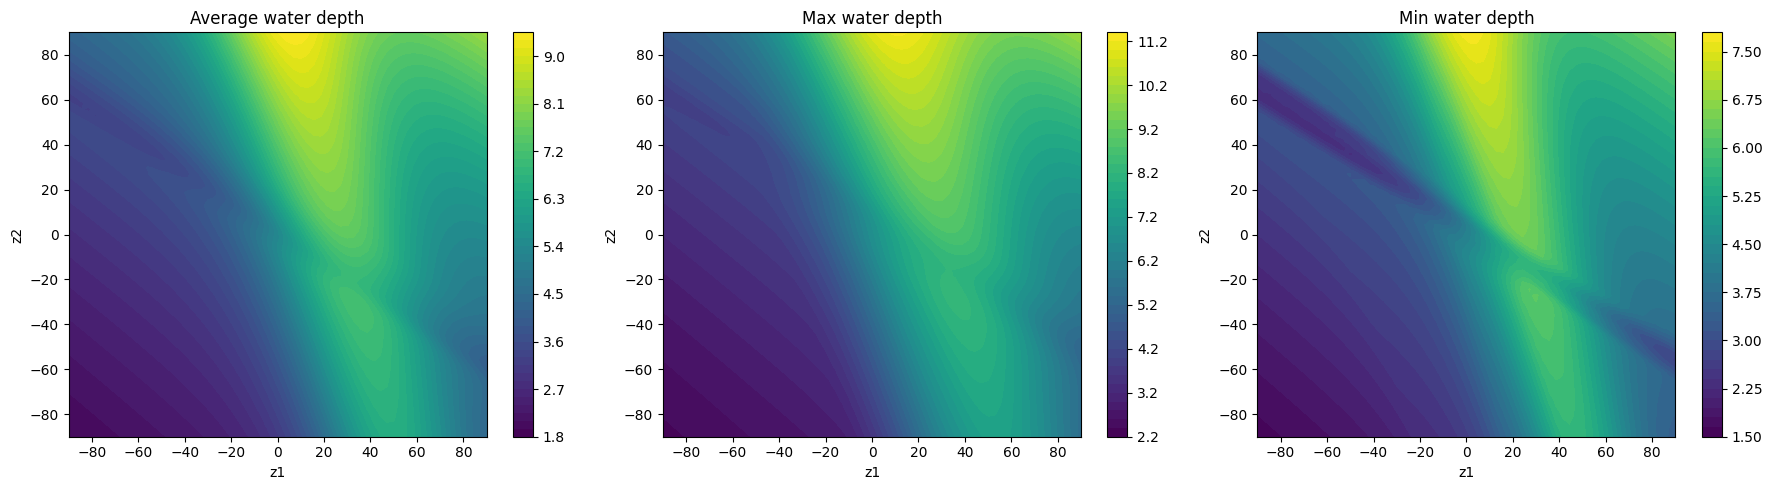

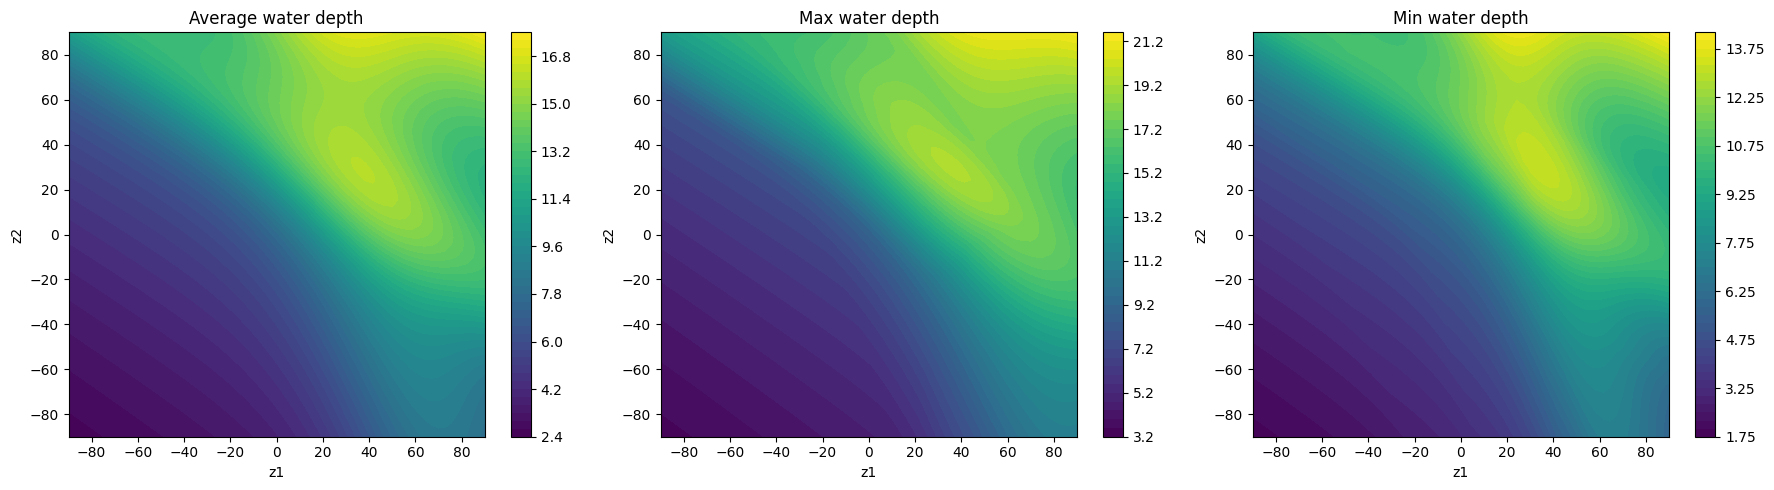

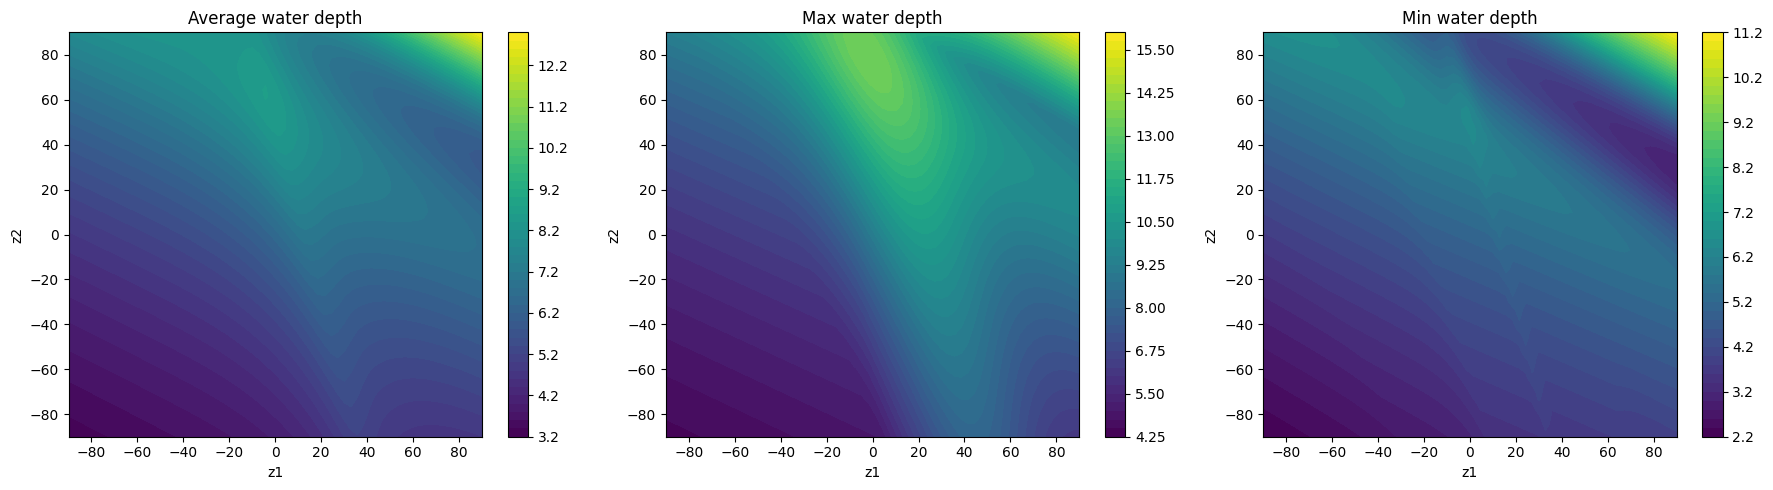

In [7]:
for i in range(3):
    e=best_plan_values[i]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # moyenne
    im0 = axes[0].contourf(Z1, Z2, HE_moyenne(e, Z1, Z2), levels=50, cmap='viridis')
    fig.colorbar(im0, ax=axes[0])
    axes[0].set_title("Average water depth")
    axes[0].set_xlabel("z1")
    axes[0].set_ylabel("z2")

    # max
    im1 = axes[1].contourf(Z1, Z2, HE_max(e, Z1, Z2), levels=50, cmap='viridis')
    fig.colorbar(im1, ax=axes[1])
    axes[1].set_title("Max water depth")
    axes[1].set_xlabel("z1")
    axes[1].set_ylabel("z2")

    # min
    im2 = axes[2].contourf(Z1, Z2, HE_min(e, Z1, Z2), levels=50, cmap='viridis')
    fig.colorbar(im2, ax=axes[2])
    axes[2].set_title("Min water depth")
    axes[2].set_xlabel("z1")
    axes[2].set_ylabel("z2")

    plt.tight_layout()
    plt.show()

In [ ]:
n_test = 2000
n_train = 200

x_test = test_values  # shape = (2000,8,36)
y_test = np.zeros((n_test,n_grid*n_grid))   # shape = (2000, 4096)

x_train = best_plan_values # shape = (200,8,36)
y_train = np.zeros((n_train,n_grid*n_grid))   # shape = (200, 4096)

#On calcul les sorties y avec le Simulateur
for i in range(n_train):
    ytrain_i = HE_max(x_train[i], Z1, Z2)
    y_train[i,:] = ytrain_i.flatten()
for i in range(n_test):
    ytest_i = HE_max(x_test[i], Z1, Z2)
    y_test[i,:] = ytest_i.flatten()

On a maintenant tous les ingrédients pour appliquer nos méthodes de prédiction. On va donc utiliser les processus gaussiens avec les 3 méthodes de réduction de dimension suivantes : 
- ACP classique
- B-spline et ACP
- Ondelettes et ACP


In [9]:
n_pc = 5  # On choisit arbitrairement le nombre de composantes principales (d'après la thèse, 5 semble un bon compromis)
theta = 3 # On choisit arbitrairement la valeur de theta 
sigma = 1 # et de sigma


--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [222.99162]            │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 7.46438                │
├─────────────────

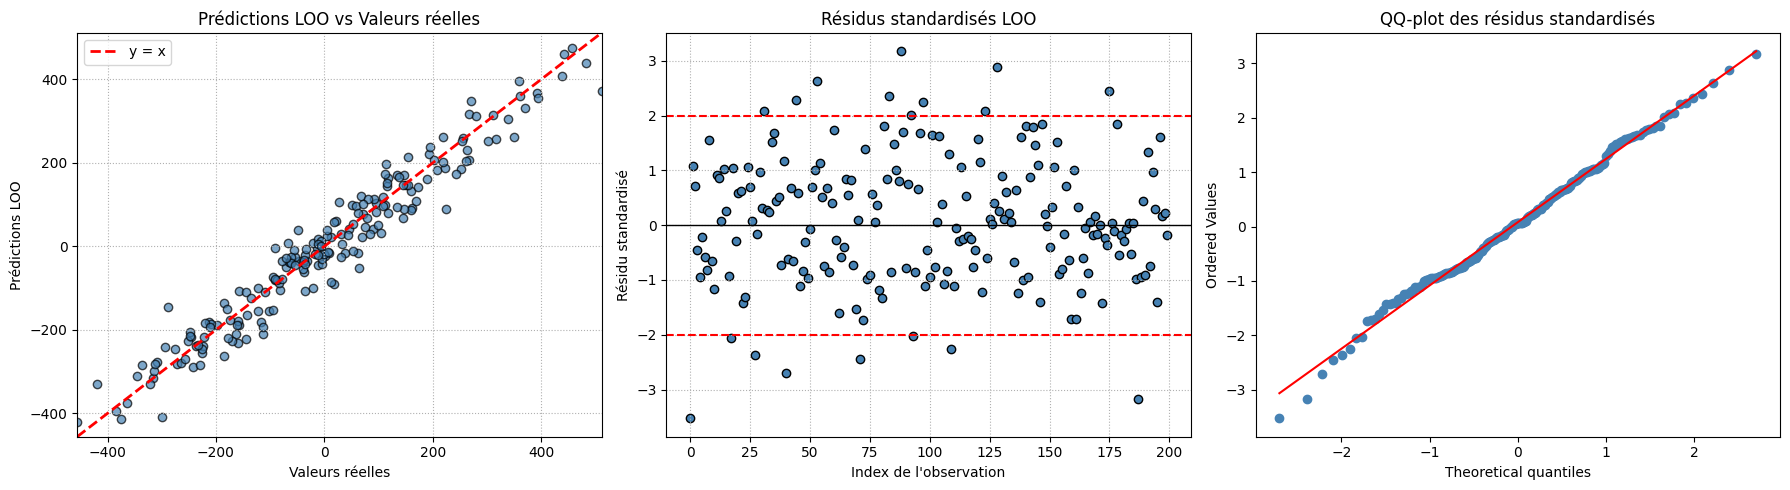


--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-14.96244]            │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 5.72121                │
├─────────────────

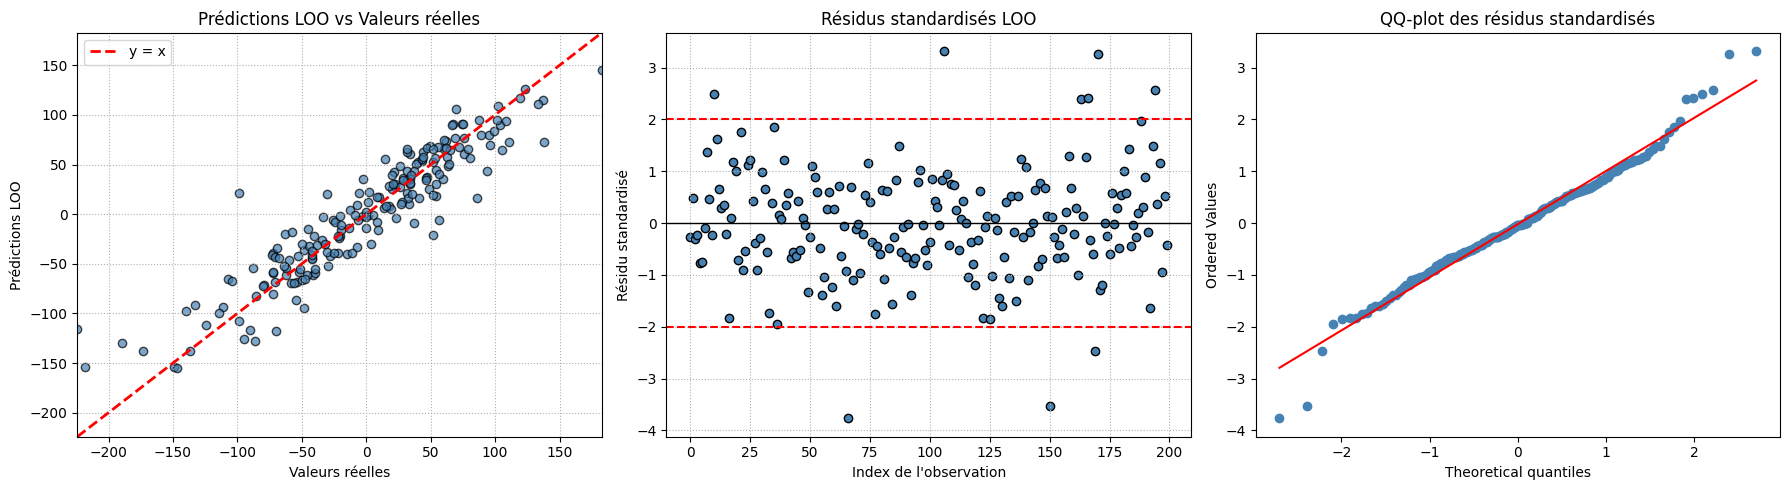


--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [23.46369]             │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 4.61566                │
├─────────────────

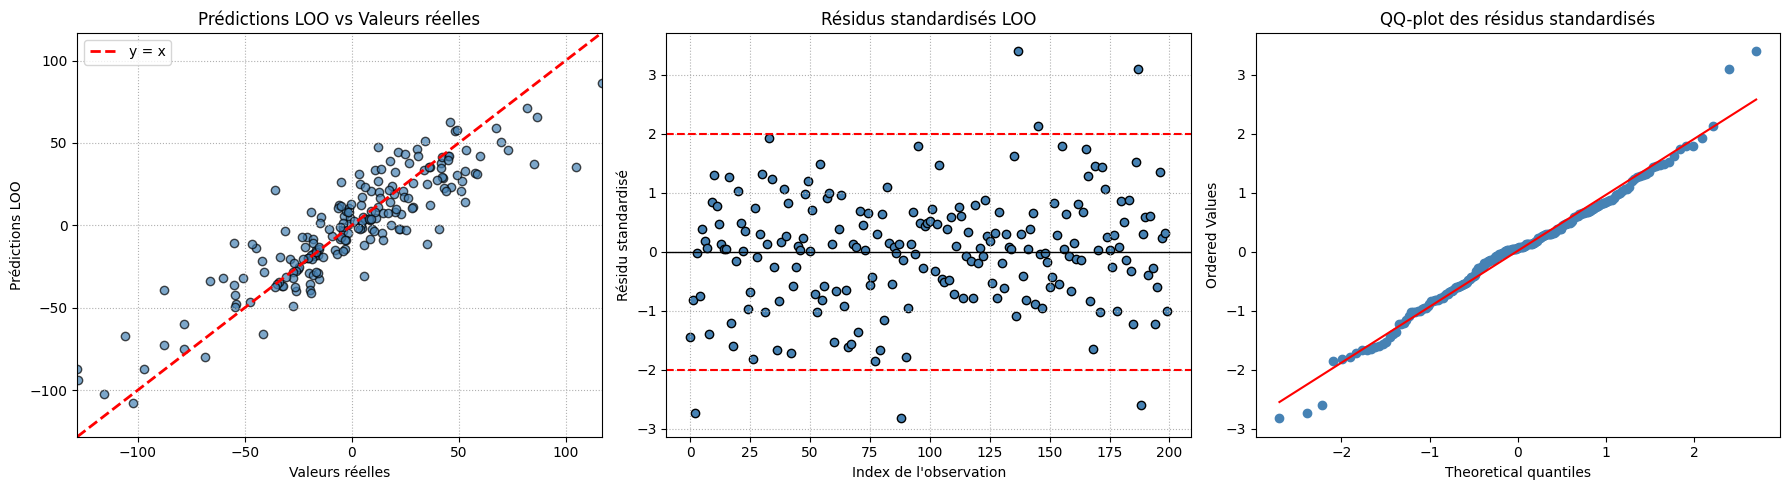


--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-11.89648]            │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.99284                │
├─────────────────

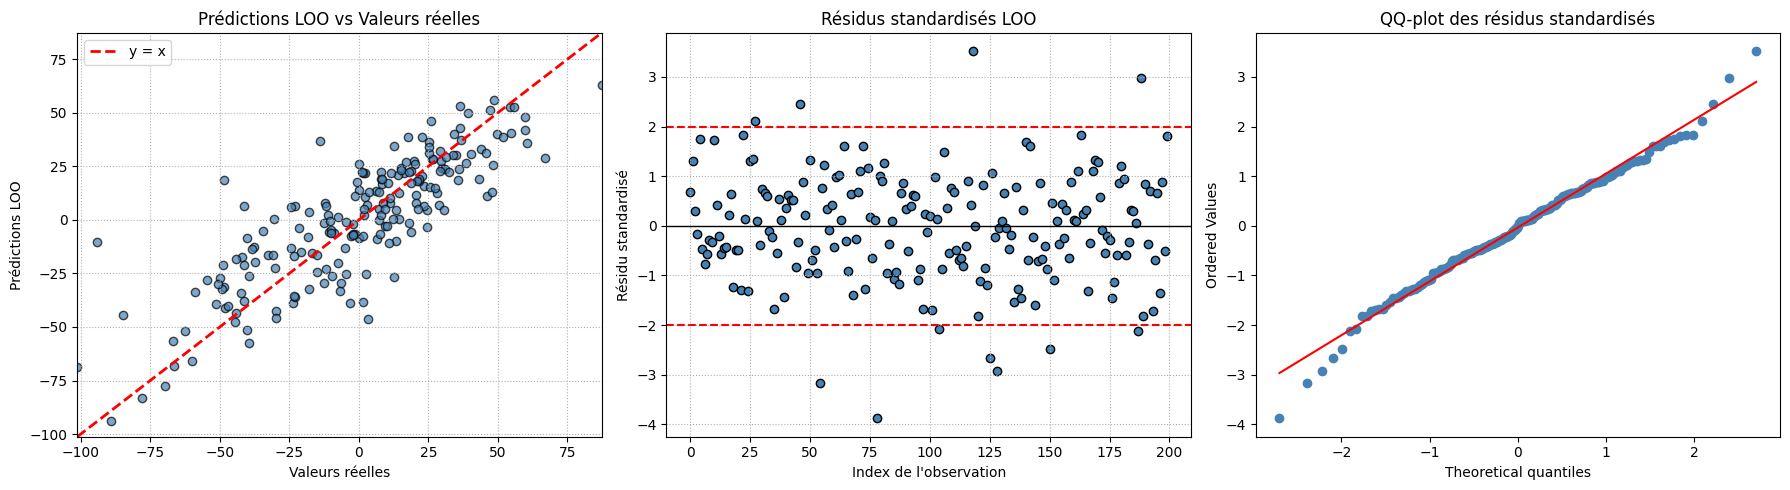


--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [3.52111]              │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.5282                 │
├─────────────────

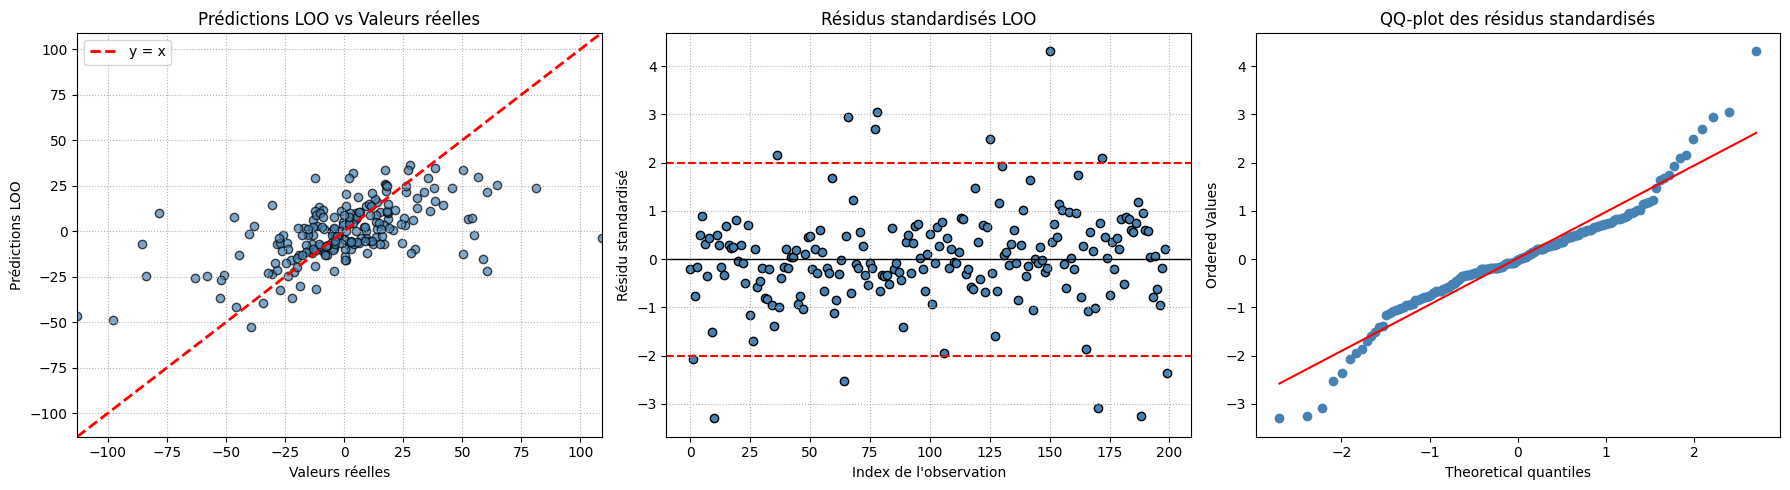

--- Analyse en Composantes Principales ---
Variance expliquée par les 5 premières composantes : [0.79682674 0.10052585 0.03330781 0.02368507 0.01799693]
Variance globale expliquée : 0.972342384444612
Taille du jeu d'entrainement transformé par ACP : (200, 5)


In [10]:
ACP = model_class.ACP_classique(n_pc,[theta,sigma])
ACP.train(x_train,y_train,verbose=True)

In [11]:
Y_test_reconstruct_ACP = ACP.predict(x_test)

Prédiction en cours...


In [12]:
# B-spline
txy = np.concatenate((
    np.repeat(-90, 2),
    np.arange(-80, 91, 10),
    np.repeat( 90, 2)
))
print("Le vecteur de noeuds utilisé pour la décompostion B-spline :",txy)
noeuds=[txy,txy]
domaine=[z1_vals,z2_vals]

Bsplines = model_class.ACPF_Bsplines(n_pc,[theta,sigma],noeuds,domaine)
Bsplines.train(x_train,y_train,verbose=True)

Le vecteur de noeuds utilisé pour la décompostion B-spline : [-90 -90 -80 -70 -60 -50 -40 -30 -20 -10   0  10  20  30  40  50  60  70
  80  90  90  90]

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyper

In [13]:
Y_test_reconstruct_Bsplines=Bsplines.predict(x_test)

Prédiction en cours...


In [14]:
# Ondelettes 
p = 0.99999 #Il faut mettre un p quasiment égal à 1 pour obtenir un résultat satisfaisant
Ondelettes = model_class.ACPF_Ondelettes(n_pc,[theta,sigma],p,2)
Ondelettes.train(x_train,y_train,verbose=True)

Nombre de coefficients conservés pour l'ACP : 1384

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée.
--- Analyse en Composantes Principales ---
Variance expliquée pa

In [15]:
Y_test_reconstruct_wavelet = Ondelettes.predict(x_test)

Prédiction en cours...


Nombre de coefficients conservés pour l'ACP : 598
(200, 598)

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [223.0144]            │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()     

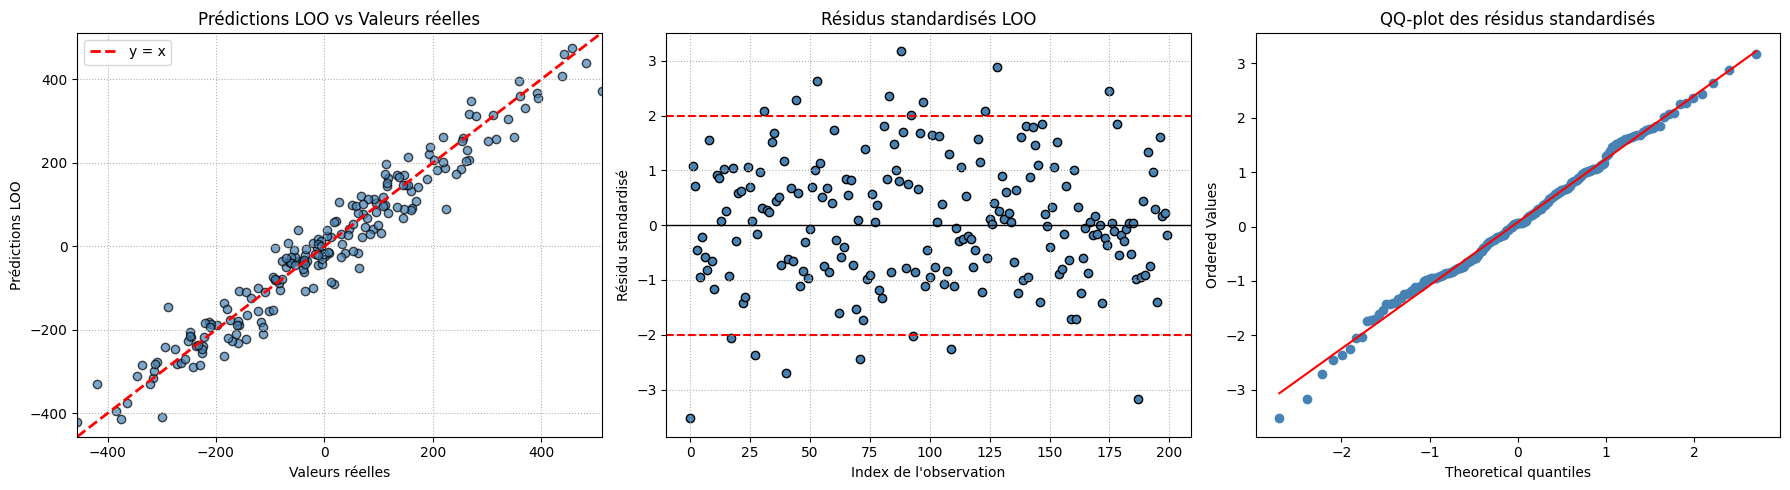


--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-14.96206]           │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 5.72118               │
├───────────────────────

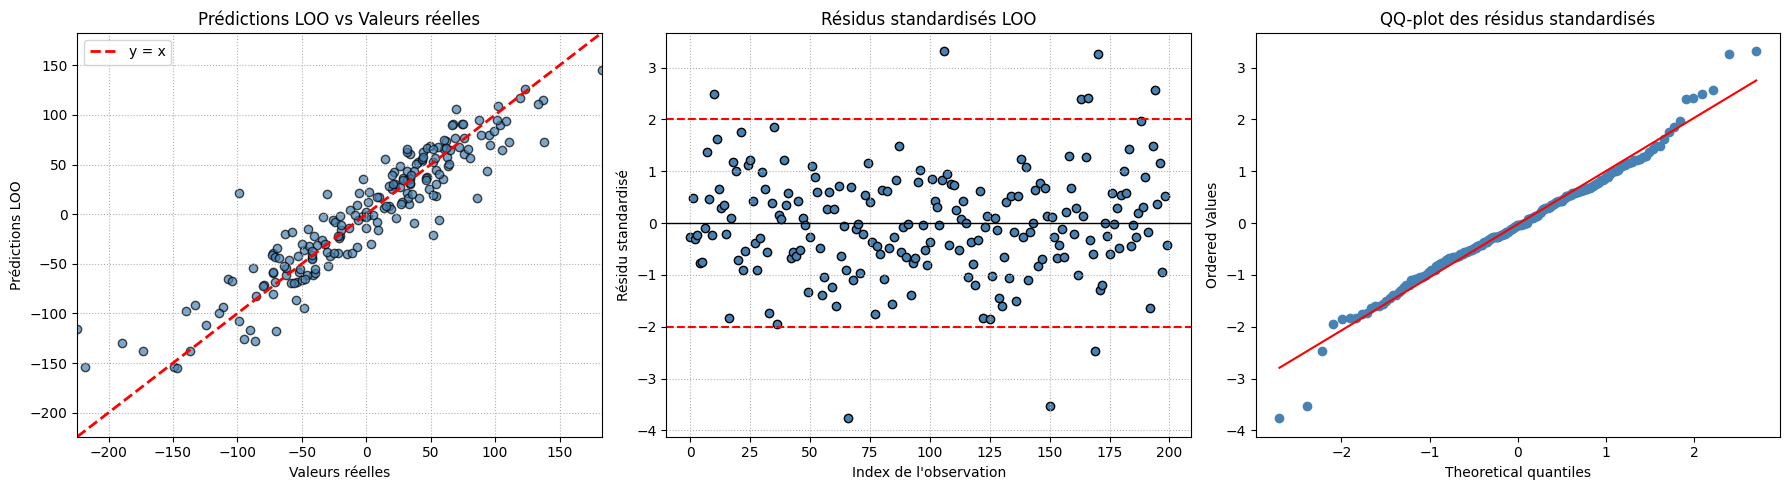


--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [23.46319]             │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 4.61565                │
├─────────────────

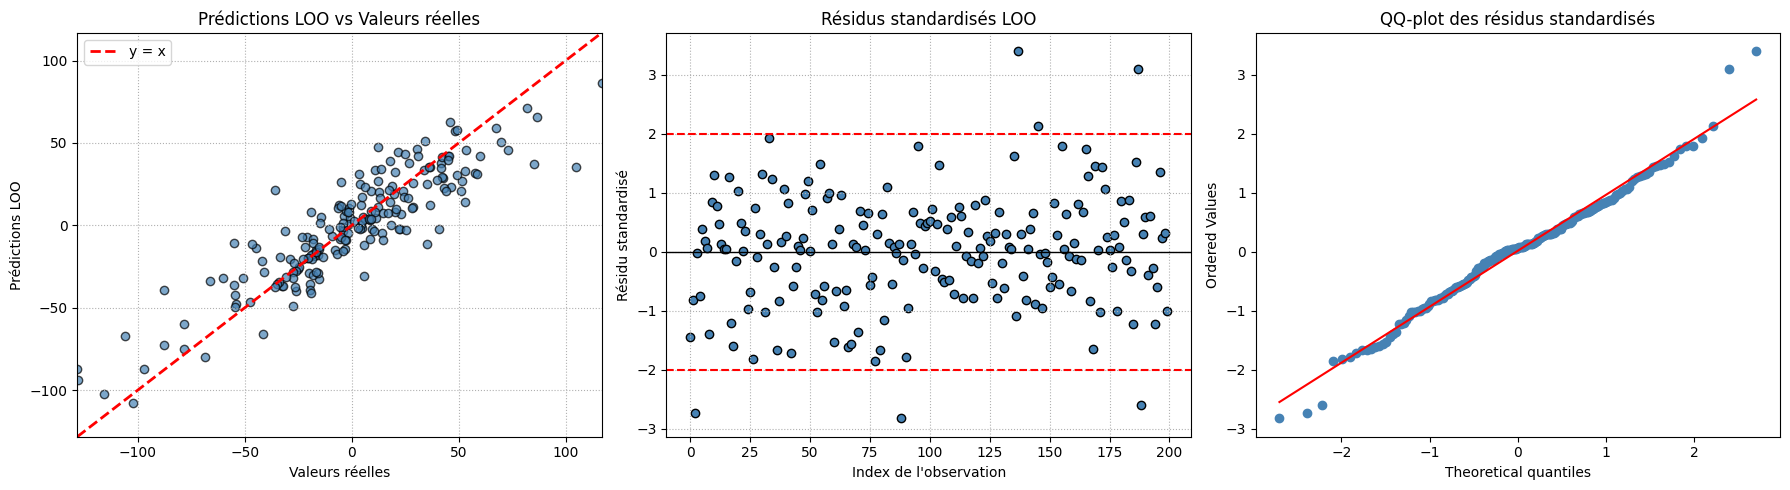


--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-11.89546]            │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.99276                │
├─────────────────

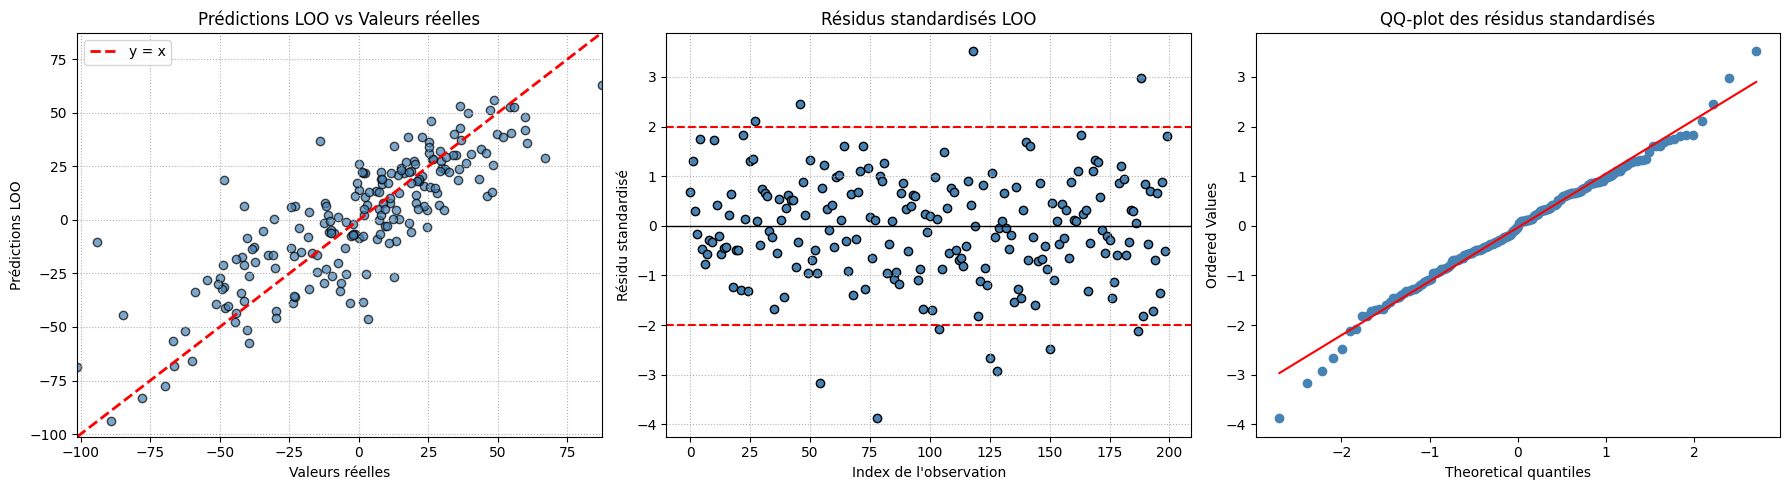


--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [3.51487]             │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.52842               │
├───────────────────────

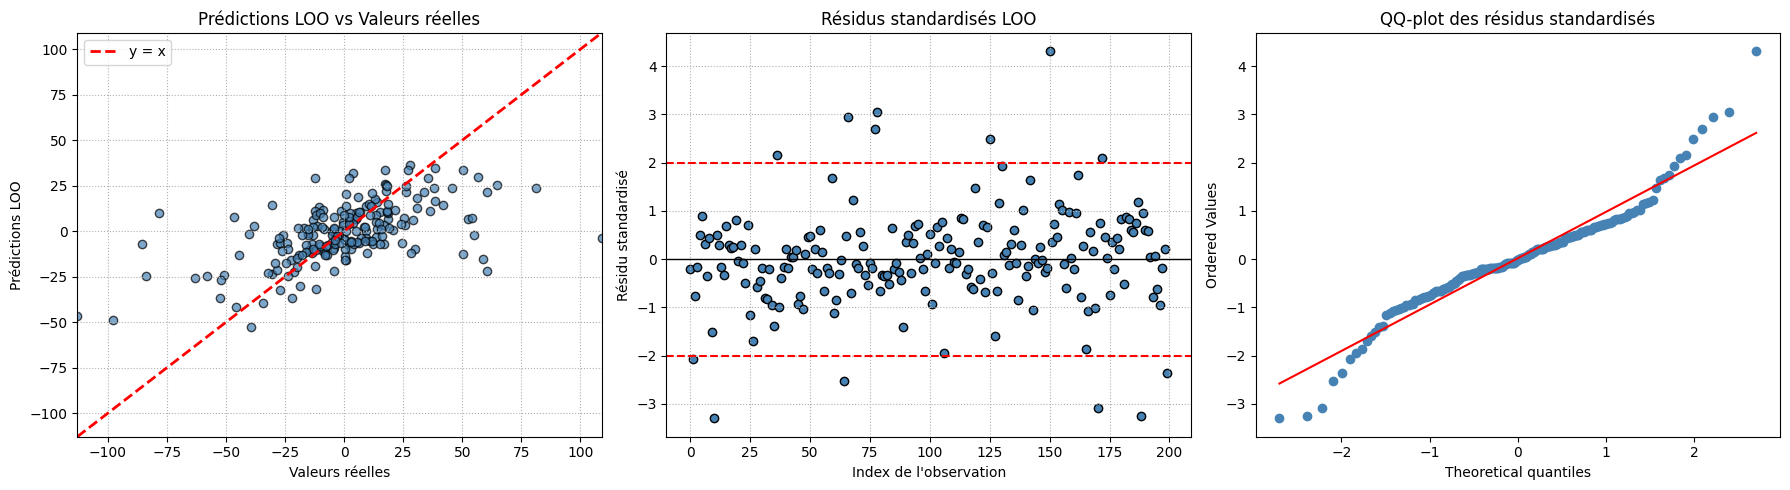

--- Analyse en Composantes Principales ---
Variance expliquée par les 5 premières composantes : [0.79687872 0.10053003 0.03330897 0.0236859  0.0179975 ]
Variance globale expliquée : 0.9724011225287056
Taille du jeu d'entrainement transformé par ACP : (200, 5)


In [16]:
y_train_2D = y_train.reshape(n_train, n_grid, n_grid)
y_test_2D = y_test.reshape(n_test, n_grid, n_grid)
Ondelettes2D = model_class.ACPF_Ondelettes2D(n_pc,[theta,sigma],p,2)
Ondelettes2D.train(x_train,y_train_2D,verbose=True)

In [17]:
Y_test_reconstruct_wavelet2D = Ondelettes2D.predict(x_test)

Prédiction en cours...


c:\Users\sliss\anaconda3\envs\PIR\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(3,)


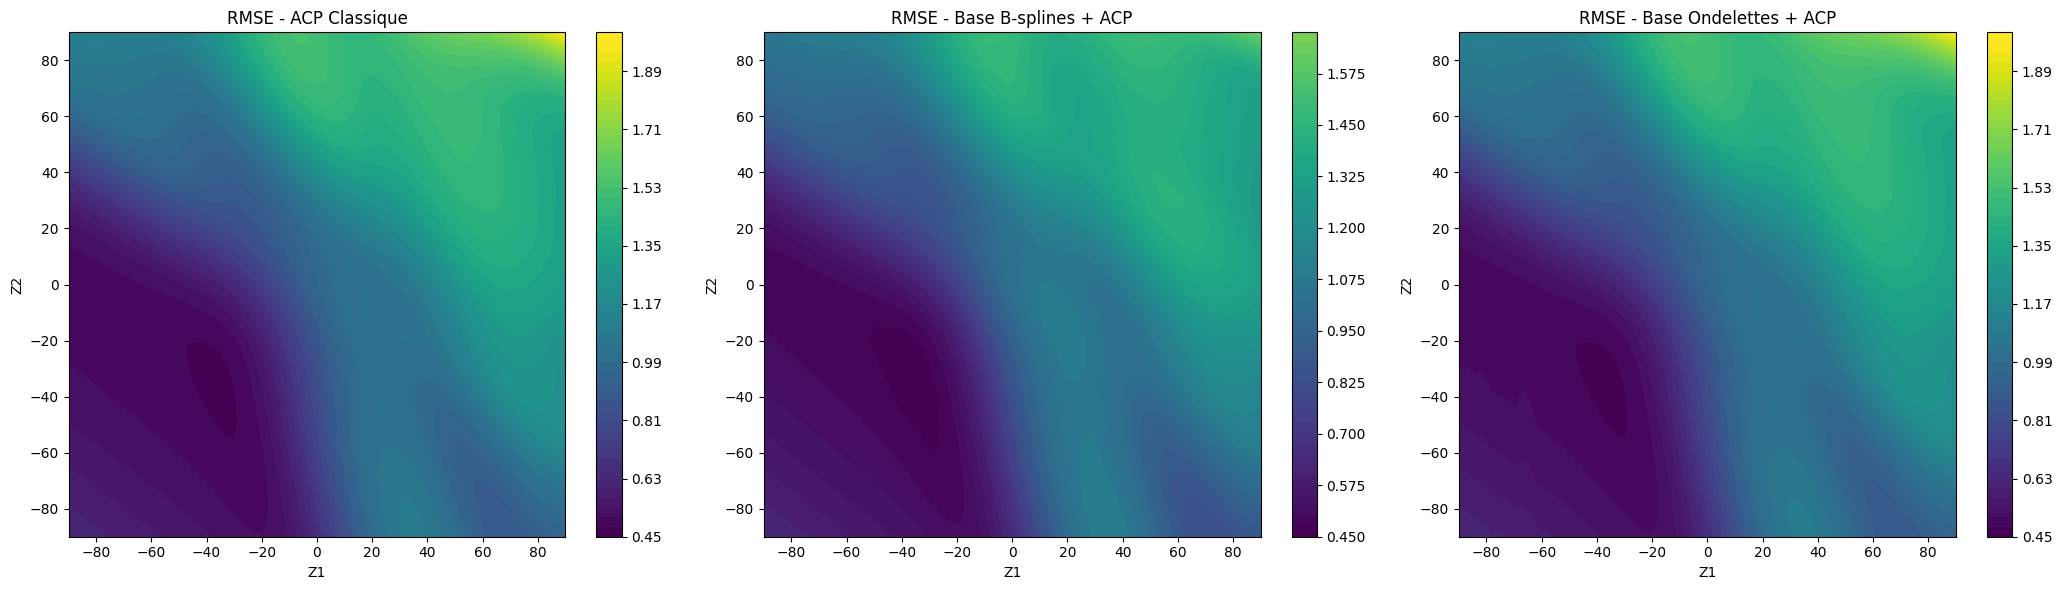

In [20]:
# --- Calcul RMSE pixel-par-pixel (ACP classique)
def RMSE_map(test, test_reconstruct):
    return np.sqrt(np.mean((test - test_reconstruct)**2, axis=0)).reshape((n_grid, n_grid))

RMSE_map_ACP = RMSE_map(y_test, Y_test_reconstruct_ACP)
RMSE_map_BS = RMSE_map(y_test, Y_test_reconstruct_Bsplines)
RMSE_map_wavelet = RMSE_map(y_test, Y_test_reconstruct_wavelet)
RMSE_map_wavelet2D = RMSE_map(y_test, Y_test_reconstruct_wavelet2D.reshape(n_test, n_grid*n_grid))

# --- Trouver les min/max communs pour la même échelle colorimétrique
vmin = min(RMSE_map_ACP.min(), RMSE_map_BS.min(), RMSE_map_wavelet.min(), RMSE_map_wavelet2D.min())
vmax = max(RMSE_map_ACP.max(), RMSE_map_BS.max(), RMSE_map_wavelet.max(), RMSE_map_wavelet2D.max())

# --- Plot côte à côte
plt.figure(figsize=(21, 6))

# ACP classique
plt.subplot(1, 3, 1)
contour1 = plt.contourf(Z1, Z2, RMSE_map_ACP, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour1)
plt.title("RMSE - ACP Classique")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + B-splines
plt.subplot(1, 3, 2)
contour2 = plt.contourf(Z1, Z2, RMSE_map_BS, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour2)
plt.title("RMSE - Base B-splines + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + Ondelettes
plt.subplot(1, 3, 3)
contour3 = plt.contourf(Z1, Z2, RMSE_map_wavelet, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour3)
plt.title("RMSE - Base Ondelettes + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + Ondelettes 2D
# plt.subplot(1, 4, 4)
# contour4 = plt.contourf(Z1, Z2, RMSE_map_wavelet2D, levels=50,vmin = vmin, vmax=vmax)
# plt.colorbar(contour4)
# plt.title("RMSE - Base Ondelettes 2D + ACP")
# plt.xlabel("Z1")
# plt.ylabel("Z2")

plt.tight_layout()
plt.show()